# **CS452 Project (State Farm Distracted Driver Detection)**
By Radheem Razi (K163645), Abdul Mannan (K163620), Murtaza Multanwala (K163618), Shahyar (K163750) & Saira (K163665)

## **Introduction**
This notebook is part of our Deep Learning for Visual Perception (CS452) project for Spring '20


We are trying to solve the problem of detecting distracted drivers by participating in a featured Kaggle competition called "State Farm Distracted Driver Detection".
This dataset is available on Kaggle, under the State Farm competition: https://www.kaggle.com/c/state-farm-distracted-driver-detection
This notebook mostly revolves around investigating and visualizing the given dataset.

Referenced Notebook: https://www.kaggle.com/ismailchaida/cnn-to-detect-driver-actions

### Importing Libraries

In [1]:
import os
import glob
import random
import gc
import pickle
import time
import tensorflow
import datetime
import math
from skimage import color

os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed


from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline

from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2
import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19


from keras.utils import to_categorical
from keras.models import Model
from keras import optimizers

from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import classification_report
from keras.callbacks import LearningRateScheduler

### Importing the Dataset

In [2]:
dataset = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [3]:
img_rows = 224
img_cols = 224
color_type = 3

In [4]:
start_time = time.time()
driver_details = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv',na_values='na')

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("../input/state-farm-distracted-driver-detection/imgs/train/c"+str(i))
    print(len(imgs))
    for j in range(1900):               ########comment range(len(imgs)):#1900 (DUE TO MEMORY LIMITATIONS UNDERSAMPLED DATASET HERE)
                                                                         #  (In colab notebook all training images are considered when training)                     
        
        img_name = "../input/state-farm-distracted-driver-detection/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        
        #img = Image.open(img_name)
        #wpercent = (img_rows/float(img.size[0]))
        #hsize = int((float(img.size[1])*float(wpercent)))
        #img = img.resize((img_rows,hsize), PIL.Image.ANTIALIAS)
        #img=np.array(img)
        #img=img/255
        
        #img = color.rgb2gray(img)
        #img = img[50:,120:-50]           ########uncomment to crop
        
        img = cv2.resize(img,(img_rows,img_cols))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)
if not os.path.exists('cache'):        
        os.mkdir('cache')
        
file = open('cache/train224.dat', 'wb')  ##saving cache to save time 
pickle.dump(train_image, file)
file.close()
print("--- %s seconds ---" % (time.time() - start_time))

now we are in the folder C 0
2489
now we are in the folder C 1
2267
now we are in the folder C 2
2317
now we are in the folder C 3
2346
now we are in the folder C 4
2326
now we are in the folder C 5
2312
now we are in the folder C 6
2325
now we are in the folder C 7
2002
now we are in the folder C 8
1911
now we are in the folder C 9
2129
--- 296.3880407810211 seconds ---


Class imbalance problem exists hence prevented (in this notebook) by under sampling technique

In [ ]:
#Retrieving cache dataset
train_image = []
file = open('cache/train224.dat', 'rb')
train_image=pickle.load(file)
file.close()

## Train and validation split based on driver ids

**Eliminating Data leakage**

> For Random drivers:

In [6]:
# ## getting list of driver names

# D = []
# for features,labels,drivers in train_image:
#     D.append(drivers)

# ## Deduplicating drivers

# deduped = []

# for i in D:
#     if i not in deduped:
#         deduped.append(i)
    

# ## selecting random drivers for the validation set
# driv_selected = []
# import random
# driv_nums = random.sample(range(len(deduped)), 4)
# for i in driv_nums:
#     driv_selected.append(deduped[i])


> Explicitly mentioned drivers (Based on random CV)

In [7]:
driv_selected =  ['p061', 'p035', 'p056', 'p052','p042'] 
X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []
true_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
        true_test.append(labels)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

15783 3217
15783 3217


In [12]:

X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
img_rows=X_train.shape[1]
img_cols=X_train.shape[2]
print(img_rows,img_cols)

print (X_train.shape)
print(y_train.shape)

224 224
(15783, 224, 224, 3)
(15783, 10)


#### Statistics

In [8]:
# Statistics
from glob import glob

# Load the list of names
names = [item[17:19] for item in sorted(glob("../input/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('..', 'input/imgs', 'test', '*.jpg'))))
x_train_size = len(X_train)
categories_size = len(names)
x_test_size = len(X_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 19000 total images.

There are 15783 training images.
There are 0 total training categories.
There are 3217 validation images.
There are 0 test images.


### Dataset Visualization

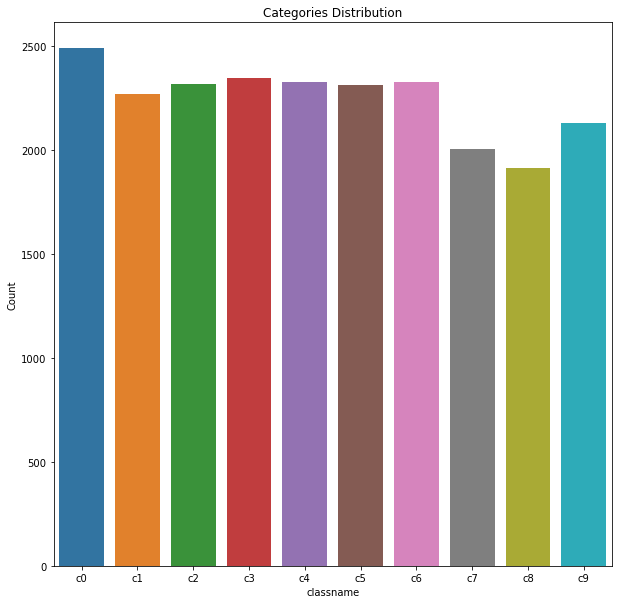

In [9]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [10]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

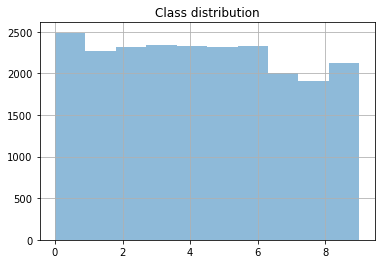

In [11]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

### **Images belonging to different categories**

In [13]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

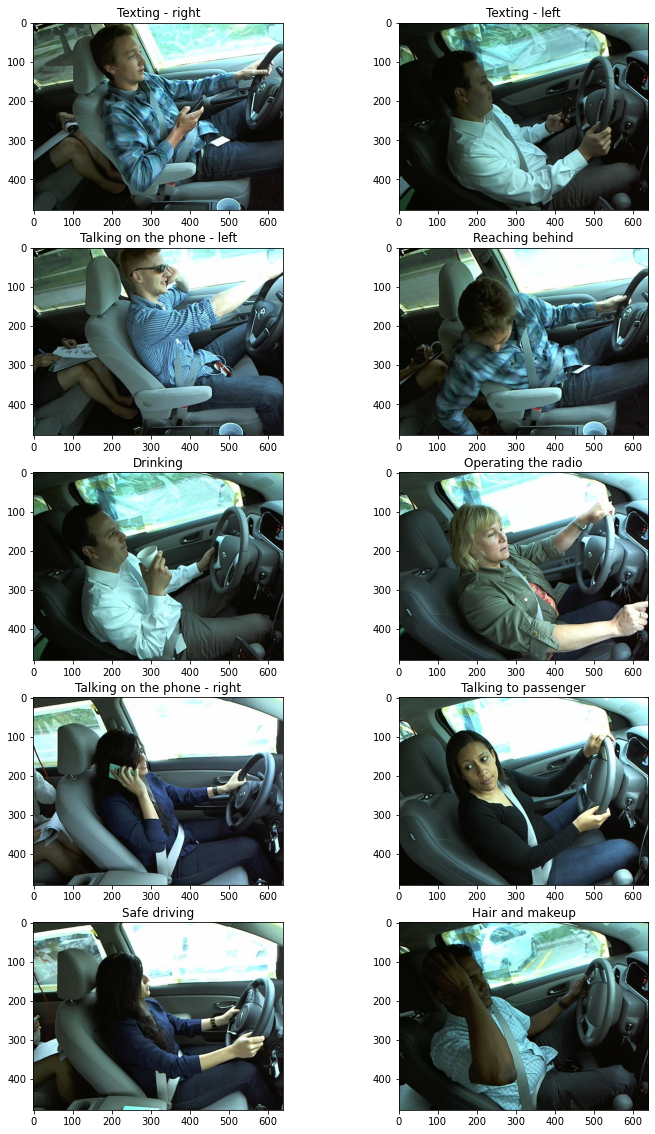

In [15]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../input/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])